# Graph Attention Networks Test
* code modified from [here](https://www.youtube.com/watch?v=AWkPjrZshug)

In [1]:
# import necessary packages
# standard
import numpy as np
from scipy import sparse
import pandas as pd
import networkx as nx

# plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from IPython.display import Javascript

# torch
import torch
import torch.nn.functional as F
from torch.nn import Linear

# torch geometric
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import (GCNConv, GATConv)
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import (NormalizeFeatures, RandomNodeSplit)
from torch_geometric.data import Data
from torch_geometric import seed_everything

# sklearn
from sklearn.datasets import (make_blobs, make_circles)
from sklearn.manifold import TSNE

In [2]:
# set random seeds + global options
random_seed = 43
torch.manual_seed(1234567)
seed_everything(random_seed)
accuracy_list = []

In [3]:
# make synthetic dataset
X, y = make_blobs(n_samples=200, 
                  n_features=2, 
                  centers=1, 
                  cluster_std=0.5, 
                  random_state=random_seed)

# center at origin
X = X - np.mean(X, axis=0)

X1, y1 = make_circles(n_samples=(600, 200),
                      noise = 0.04,
                      factor=0.5,
                      random_state=random_seed)

# add 1 to (make_circles) labels to account for (make_blobs) label
y1 += 1

# increase the radius
X1 = X1*3

X = np.concatenate((X, X1), axis=0)
y = np.concatenate((y, y1), axis=0)

In [4]:
# plot options
plot_colors = cm.tab10.colors
y_colors = np.array(plot_colors)[y]

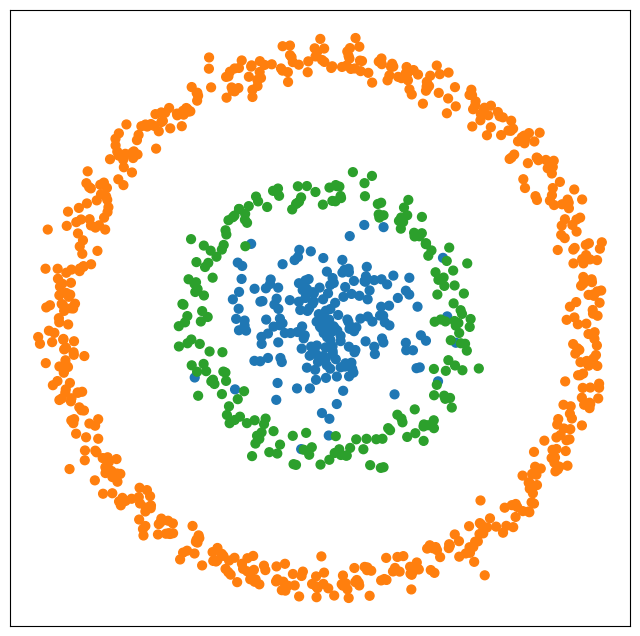

In [5]:
# plot 
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:,0], X[:,1], 
           marker='o', 
           s=40,
           color=y_colors)
ax.tick_params(axis='both', 
               which='both', 
               bottom=False,
               top=False, 
               left=False, 
               right=False,
               labelbottom=False, 
               labeltop=False,
               labelleft=False,
               labelright=False)
ax.set(xlabel=None, ylabel=None)
plt.show()

In [6]:
# create adjacency matrix
# n x n matrix, where each element represents similarity bt nodes
sigma = 1
A = -1 * np.square(X[:, None, :] - X[None, :, :]).sum(axis=-1)
A = np.exp(A / (2 * sigma ** 2))
np.fill_diagonal(A, 0)

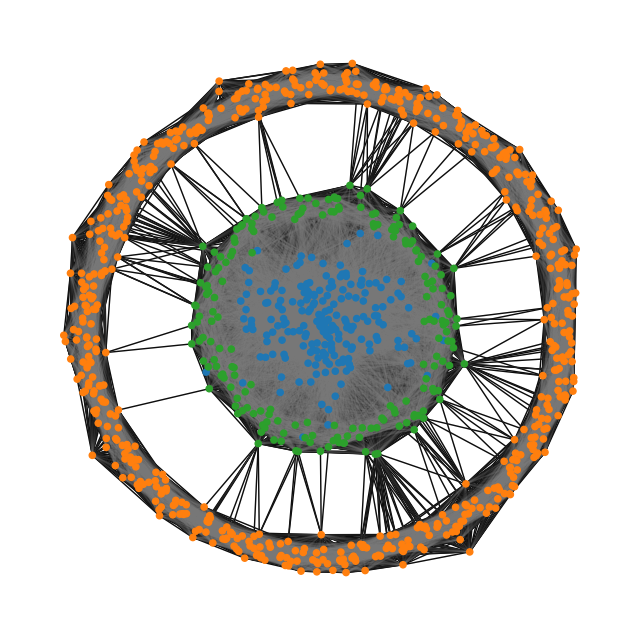

In [10]:
# only keep edges > 0.5
A1 = np.copy(A)
A1[A1 < 0.5] = 0
G = nx.from_numpy_array(A1)

# plot graph
plt.figure(figsize=(8, 8))
plt.axis('off')
nx.draw_networkx(G, 
                 pos=X, 
                 node_size=20, 
                 node_color=y_colors,
                 alpha=1,
                 with_labels=False)
nx.draw_networkx_edges(G, 
                       pos=X,
                       edge_color='gray', 
                       alpha=0.1)
plt.show()

In [12]:
# get num fts/classes
A = A1
num_features = X.shape[1]
num_classes = np.unique(y).shape[0]

# create edge list
edge_index, _ = from_scipy_sparse_matrix(sparse.csr_matrix(A))

# create pyg data object
data_synthetic = Data(x=torch.from_numpy(X.astype(np.float32)),
                      edge_index=edge_index,
                      y=torch.from_numpy(y))

# train / test split
split = RandomNodeSplit(num_val=0.1, num_test=0.1)
data_synthetic = split(data_synthetic)
data_synthetic

Data(x=[1000, 2], edge_index=[2, 100102], y=[1000], train_mask=[1000], val_mask=[1000], test_mask=[1000])

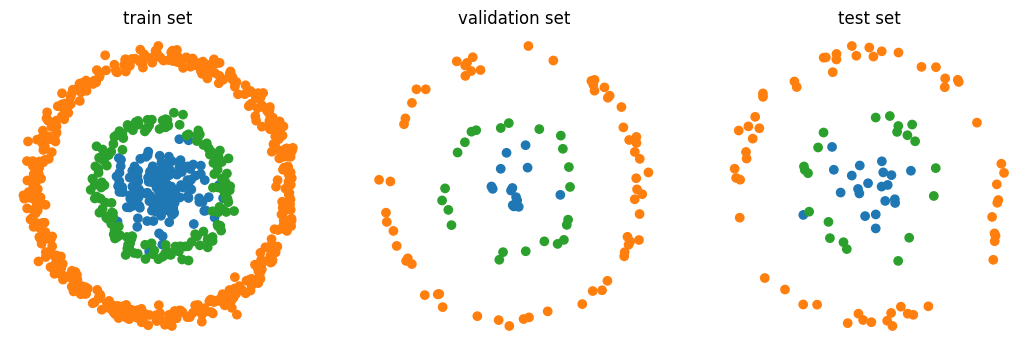

In [13]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
idxs = [data_synthetic.train_mask, data_synthetic.val_mask, data_synthetic.test_mask]
plt_label = ['train set', 'validation set', 'test set']
for i, idx in enumerate(idxs):
    axs[i].axis('off')
    axs[i].set_title(plt_label[i])
    axs[i].scatter(X[idx,0], X[idx,1], 
                   color=y_colors[idx])
plt.show()

In [14]:
# visualize with tsne function
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color)
    plt.show()

In [60]:
# define GAT
class GAT(torch.nn.Module):
    def __init__(self,
                 hidden_channels,
                 heads):
        super().__init__()
        self.conv1 = GATConv(num_features,
                             hidden_channels,
                             heads)
        self.conv2 = GATConv(hidden_channels * heads,
                             num_classes,
                             heads = 1)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [61]:
model = GAT(hidden_channels=8, heads=8)
print(model)

GAT(
  (conv1): GATConv(2, 8, heads=8)
  (conv2): GATConv(64, 3, heads=1)
)


In [63]:
# write train fn
def train(data, mask, GNN_flag):
    model.train()
    optimizer.zero_grad()
    if GNN_flag:
        out = model(data.x, data.edge_index)
    else:
        out = model(data.x)
    loss = criterion(out[mask], data.y[mask])
    loss.backward()
    optimizer.step()
    return loss

def test(data, mask, GNN_flag):
    model.eval()
    if GNN_flag:
        out = model(data.x, data.edge_index)
    else:
        out = model(data.x)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc


In [65]:
# train GAT
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(data_synthetic, data_synthetic.train_mask, GNN_flag=True)
    val_acc = test(data_synthetic, data_synthetic.val_mask, GNN_flag=True)
    test_acc = test(data_synthetic, data_synthetic.test_mask, GNN_flag=True)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}', end='\r')

accuracy_list.append(['Graph Attention', 'synthetic', test_acc])

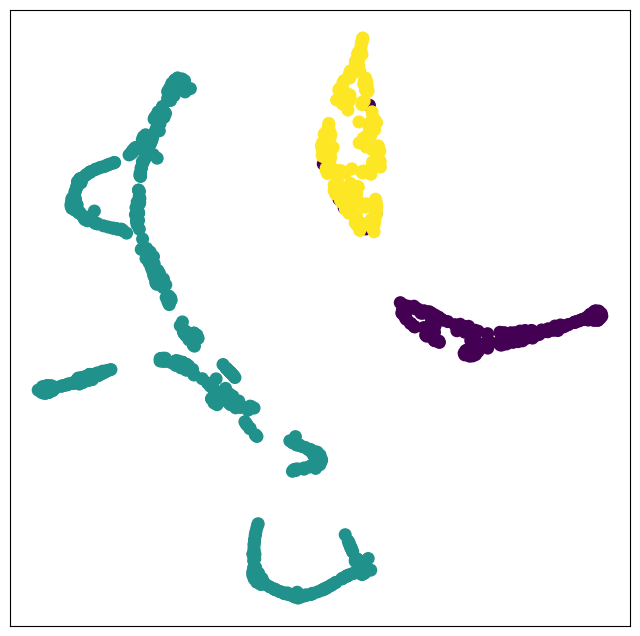

In [66]:
model.eval()
out = model(data_synthetic.x, data_synthetic.edge_index)
visualize(out, color=y)

In [68]:
# test on cora
dataset = Planetoid(root='../data/test/Cora', name='Cora', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data_Cora = dataset[0]
data_Cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [70]:
# train GAT
model = GAT(hidden_channels=16, heads=8)
optimizer = torch.optim.Adam(model.parameters(), 
                             lr = 0.01,
                             weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(data_Cora, data_Cora.train_mask, GNN_flag=True)
    val_acc = test(data_Cora, data_Cora.val_mask, GNN_flag=True)
    test_acc = test(data_Cora, data_Cora.test_mask, GNN_flag=True)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4%}, Test Acc: {test_acc:.4%}', end='\r')

accuracy_list.append(['Graph Attention', 'Cora', test_acc])


In [ ]:
# does the adjacency matrix present new information?